<a href="https://colab.research.google.com/github/marcosfelt/interview_study_plan/blob/main/algorithms/gmm_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gaussian Mixture Model

General idea:

1. Expectation (E): Calculate probability of each data point belong to each cluster using current parameters
2. Maximization (M): Update previous parameters (mean, covariance, weight) to maximize expected likelihood from step 1
Repeat 1&2 until convergence.


Math:

1. Initialization:
  1. Mean ($\mu$) and covariance ($\Sigma$) initialized randomly
  2. Weights ($\pi$): Probably that  belongs to each cluster. Often initialize to uniform.

2. Probablitiy data point $i$ belongs to cluster $c$.


  $$ r_{ic} = \frac{\pi_c \mathbb N(x_i \vert \mu_c, \Sigma_c)}{\sum_{k=1}^K \pi_k \mathbb N(x_i \vert \mu_k, \Sigma_k)} $$

  $$ \mathbb N(x_i \vert \mu_c, \Sigma_c) = \frac{1}{(2\pi)^{n/2} \vert \Sigma_c \vert^{1/2}} \exp(-\frac{-1}{2}(x_i - \mu_c)^T \Sigma_c^{-1} (x_i - \mu_c)) $$

3. Maximization: Update parameters as follows

  Cluster weights are average of probabilities of all data points:
  $$\pi_c = \frac{\sum_{i=1}^m r_{ic}}{m} $$ where $m$ is number of data points.

  Weight cluster means as probability weighted average of data points
  $$ \mu_c = \frac{\sum_{i=1}^m r_{ic}x_i}{\sum_{i=1}^m r_{ic}} $$

  Covariance:

  $$ \Sigma_c = \frac{\sum_{i=1}^m r_{ic}(x_i - \mu_c)^2}{\sum_{i=1}^m r_{ic} } $$

In [2]:
#import requred libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.stats import norm
import warnings
import random

warnings.filterwarnings('ignore')

In [3]:
# Parameters
n = 1000
seed = 100

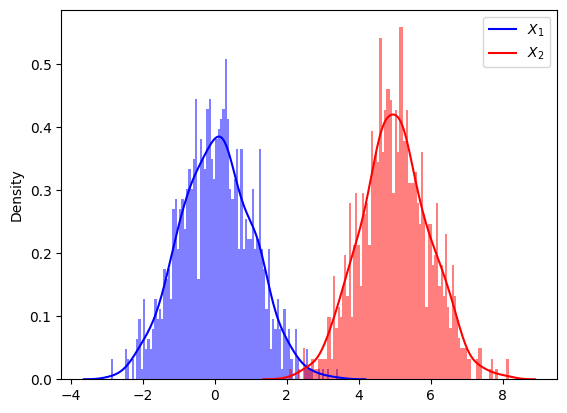

In [4]:
# Generate random data with multiple modes
rng = np.random.default_rng(seed)
x_1 = rng.normal(0, 1, n)
x_2 = rng.normal(5, 1, n)


# Plot
plt.figure()
sns.distplot(x_1, kde=True, hist=True, bins=100, color="b", hist_kws={"alpha": 0.5})
sns.distplot(x_2, kde=True, hist=True, bins=100, color="r", hist_kws={"alpha": 0.5})
plt.legend([r"$X_1$", r"$X_2$"])


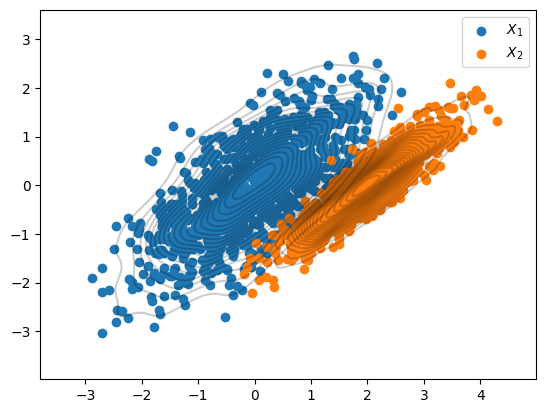

In [5]:
mu_1 = [0, 0]
mu_2 = [2, 0]
cov_1 = [[1., 0.7], [0.7, 1]]
cov_2 = [[0.5, 0.5], [0.4, 0.5]]


# Generate random data with multiple modes
rng = np.random.default_rng(seed)
x_1 = rng.multivariate_normal(mu_1, cov_1, n)
x_2 = rng.multivariate_normal(mu_2, cov_2, n)


# Plot
plt.figure()
plt.scatter(x=x_1[:,0],y=x_1[:, 1])
plt.scatter(x=x_2[:,0],y=x_2[:, 1])
sns.kdeplot(x=x_1[:,0],y=x_1[:, 1], levels=20, linewidth=10, color="k", alpha=0.2)
sns.kdeplot(x=x_2[:,0],y=x_2[:, 1], levels=20, linewidth=10, color="k", alpha=0.2)
plt.legend([r"$X_1$", r"$X_2$"])
plt.grid(False)

In [34]:
n_samples = 100
mu1, sigma1 = -5, 1.2
mu2, sigma2 = 5, 1.8
mu3, sigma3 = 0, 1.6

x1 = np.random.normal(loc = mu1, scale = np.sqrt(sigma1), size = n_samples)
x2 = np.random.normal(loc = mu2, scale = np.sqrt(sigma2), size = n_samples)
x3 = np.random.normal(loc = mu3, scale = np.sqrt(sigma3), size = n_samples)

X = np.concatenate((x1,x2,x3))

In [51]:
def init_parameters(c, seed=100):
  rng = np.random.default_rng(seed)
  mus = rng.normal(0, 1, c)
  variances = (rng.normal(0, 1, c))**2
  pis = 1/c * np.ones(c)
  return mus, variances, pis


def calculate_probs(x, mus, variances, pis):
  weights = np.zeros((x.shape[0], len(pis)))
  for k in range(len(pis)):
     weights[:, k]= pis[k] * norm(loc=mus[k], scale=np.sqrt(variances[k])).pdf(x)
  return weights / weights.sum(axis=1)[:, np.newaxis]

def update_parameters(r, x):
  pis = np.mean(r, axis=0)
  mus = np.zeros(len(pis))
  variances = np.zeros(len(pis))
  for k in range(len(pis)):
    mus[k] = np.dot(r[:, [k]].T, x.T) / r[:, k].sum()
    variances[k] = (r[:, k]*(x- mus[k])**2).sum() / r[:, k].sum()
  return mus, variances, pis


def plot_pdf(mu,sigma,label,alpha=0.5,linestyle='k--',density=True,color='green'):
  X = norm.rvs(mu, sigma, size=1000)

  plt.hist(X, bins=50, density=density, alpha=alpha,label=label,color=color)

  # Plot the PDF
  x = np.linspace(X.min(), X.max(), 1000)
  y = norm.pdf(x, mu, sigma)
  plt.plot(x, y, linestyle)

def plot_intermediate_steps(means,variances,density=False):
  plt.figure()

  plot_pdf(mu1,sigma1,alpha=0.0,linestyle='r--',label='Original Distibutions')
  plot_pdf(mu2,sigma2,alpha=0.0,linestyle='r--',label='Original Distibutions')
  plot_pdf(mu3,sigma3,alpha=0.0,linestyle='r--',label='Original Distibutions')

  color_gen = (x for x in ['green','blue','orange'])

  for mu,sigma in zip(means,variances):
      plot_pdf(mu,sigma,alpha=0.5,label='d',color=next(color_gen))
  plt.show()

def fit_gmm(x: np.ndarray, c: int, max_iter: int = 100) -> np.ndarray:
  # Initialize parameters
  mus, variances, pis = init_parameters(c)

  # Estimate parameters
  for iter in range(max_iter):
    # print(mus, variances, pis)
    r  = calculate_probs(x, mus, variances, pis)
    mus, variances, pis = update_parameters(r, x)
    if iter % 10 == 0:
      plot_intermediate_steps(mus, np.sqrt(variances))
  plot_intermediate_steps(mus, np.sqrt(variances))
  return mus, variances, pis

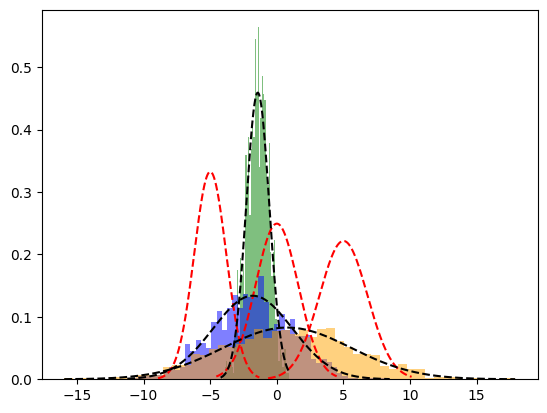

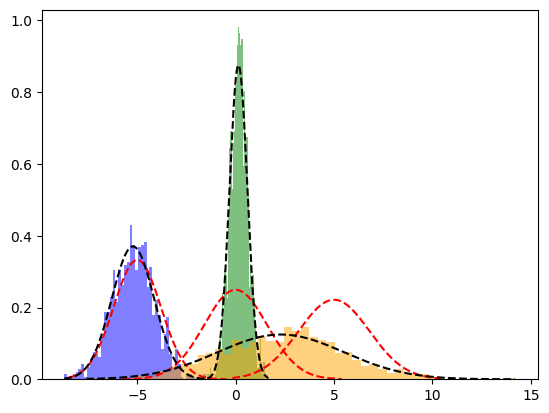

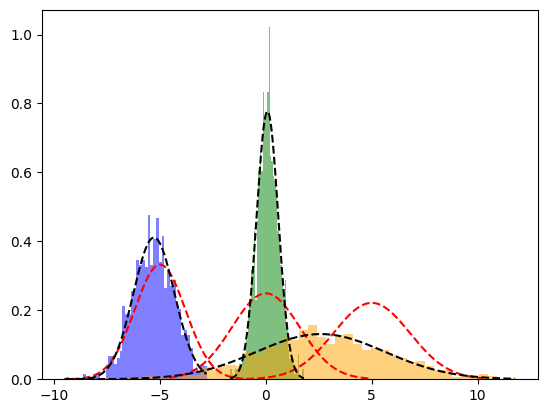

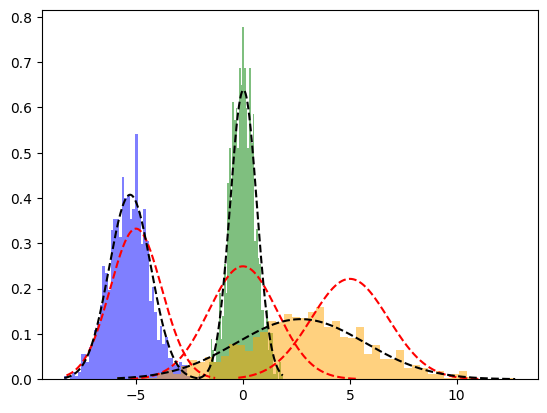

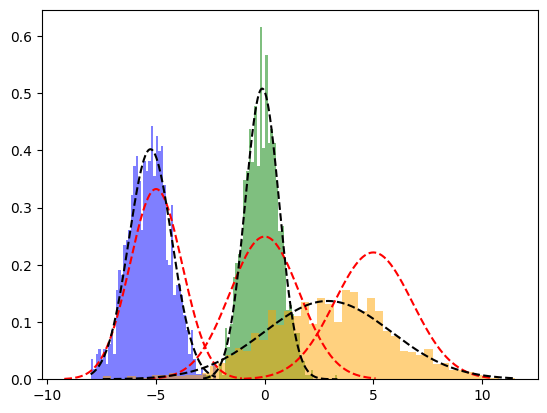

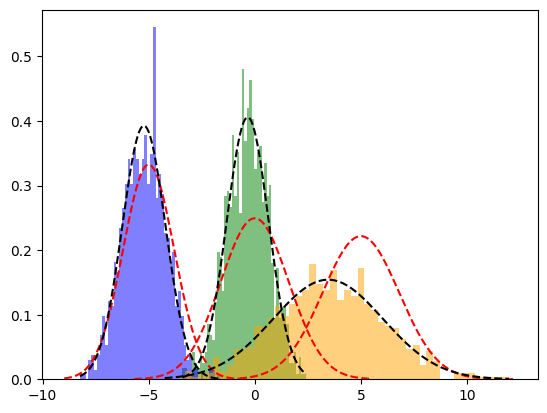

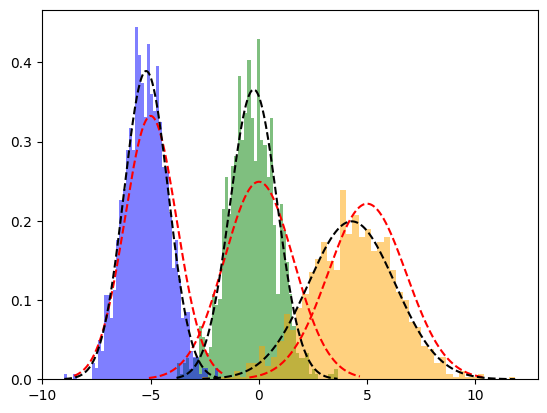

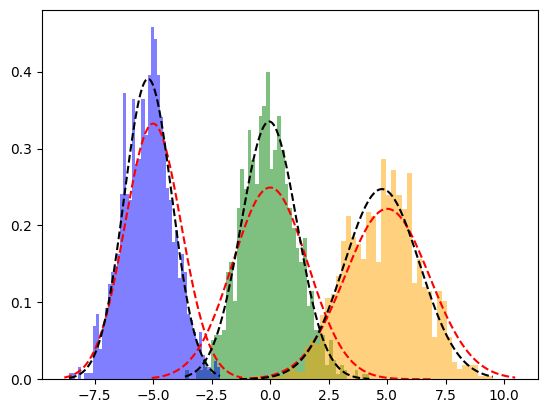

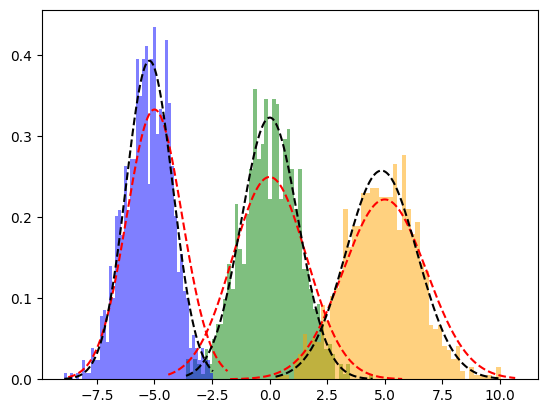

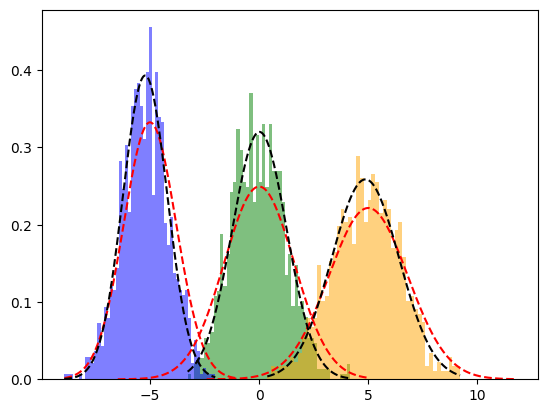

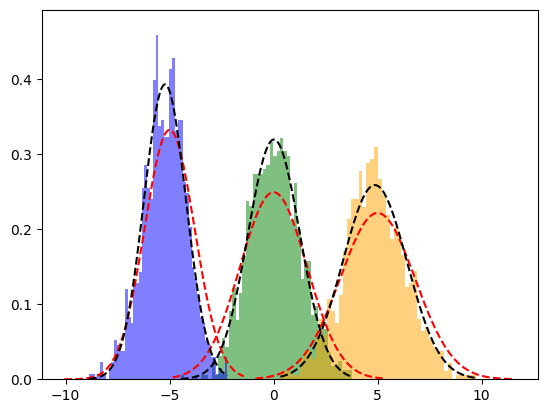

(array([ 0.01750601, -5.22099041,  4.86981434]),
 array([1.55778825, 1.02985719, 2.37469717]),
 array([0.32601451, 0.33455152, 0.33943398]))

In [52]:

fit_gmm(X, 3)



In [20]:
# Plot


array([[9.59996149e-01, 4.00038509e-02],
       [1.11134906e-01, 8.88865094e-01],
       [4.58626256e-02, 9.54137374e-01],
       ...,
       [9.99457396e-01, 5.42603820e-04],
       [9.99964775e-01, 3.52250703e-05],
       [9.91838002e-01, 8.16199762e-03]])